# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Gian Marco Paldino - __[gian.marco.paldino@ulb.be](mailto:gian.marco.paldino@ulb.be)__
### Cédric Simar - __[cedric.simar@ulb.be](mailto:cedric.simar@ulb.be)__
### Pascal Tribel - __[pascal.tribel@ulb.be](mailto:pascal.tribel@ulb.be)__

## TP 2 - Linear Models

####  February 2025

In this session, we will:
1. Generate synthetic multivariate data.
2. **Manually compute** the Ordinary Least Squares (OLS) solution (matrix form).
3. Compare manual OLS results with `statsmodels` OLS.
4. Introduce **transformations** of inputs (e.g., polynomial, RBF expansions)
5. Explore **Ridge regression** (manual formula vs. scikit-learn).

We assume basic familiarity with matrix algebra and Python packages such as numpy, pandas, and statsmodels.



## 1. Generating Synthetic Multivariate Data

We'll create a dataset where `Y` depends on three features: `X1, X2, X3`.
The true data-generating process (DGP) is:

$$
  Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \epsilon,
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.

### Steps
1. Create `N` observations of `(X1, X2, X3)`.
2. Define true coefficients `beta_true`.
3. Generate noise and produce `Y`.
4. Store everything in a DataFrame for convenience.


In [1]:
!pip install numpy pandas matplotlib seaborn statsmodels scipy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy.stats import probplot

In [3]:
np.random.seed(123)

# Number of data points
N = 200
# True noise standard deviation
sigma_true = 2.0

# True coefficients (beta0, beta1, beta2, beta3)
beta_true = np.array([5.0, 1.5, -2.0, 0.5])

# Generate X1, X2, X3
X1 = np.random.uniform(-5, 5, size=N)
X2 = np.random.uniform(-10, 10, size=N)
X3 = np.random.normal(0, 2, size=N)

# Build DataFrame
df = pd.DataFrame({'X1':X1, 'X2':X2, 'X3':X3})

# Generate the true Y (without noise)
Y_true = (beta_true[0]
          + beta_true[1]*df['X1']
          + beta_true[2]*df['X2']
          + beta_true[3]*df['X3'])

# Add noise
noise = np.random.normal(0, sigma_true, size=N)
df['Y'] = Y_true + noise

df.head()

,X1,X2,X3,Y
0,1.964692,0.852719,-3.510804,5.687964
1,-2.138607,-8.664511,-0.697215,16.509223
2,-2.731485,3.067297,-0.385230,-4.050829
3,0.513148,9.921727,0.898271,-12.453060
4,2.194690,5.387947,-0.290727,-1.697682


### Quick Data Inspection
Note: the `pairplot` function from `seaborn` includes a linear regression of the pairs of data. We will see later how to manually compute this regression.

               X1          X2          X3           Y
count  200.000000  200.000000  200.000000  200.000000
mean     0.032708   -0.193044   -0.112239    5.572700
std      2.663947    5.907073    1.963533   12.473036
min     -4.973119   -9.929356   -5.262876  -20.342999
25%     -1.953937   -5.254828   -1.286318   -4.258475
50%      0.207716   -0.714124   -0.101728    5.417761
75%      2.181854    5.168943    1.206797   14.861563
max      4.953585    9.921727    4.501352   30.849943


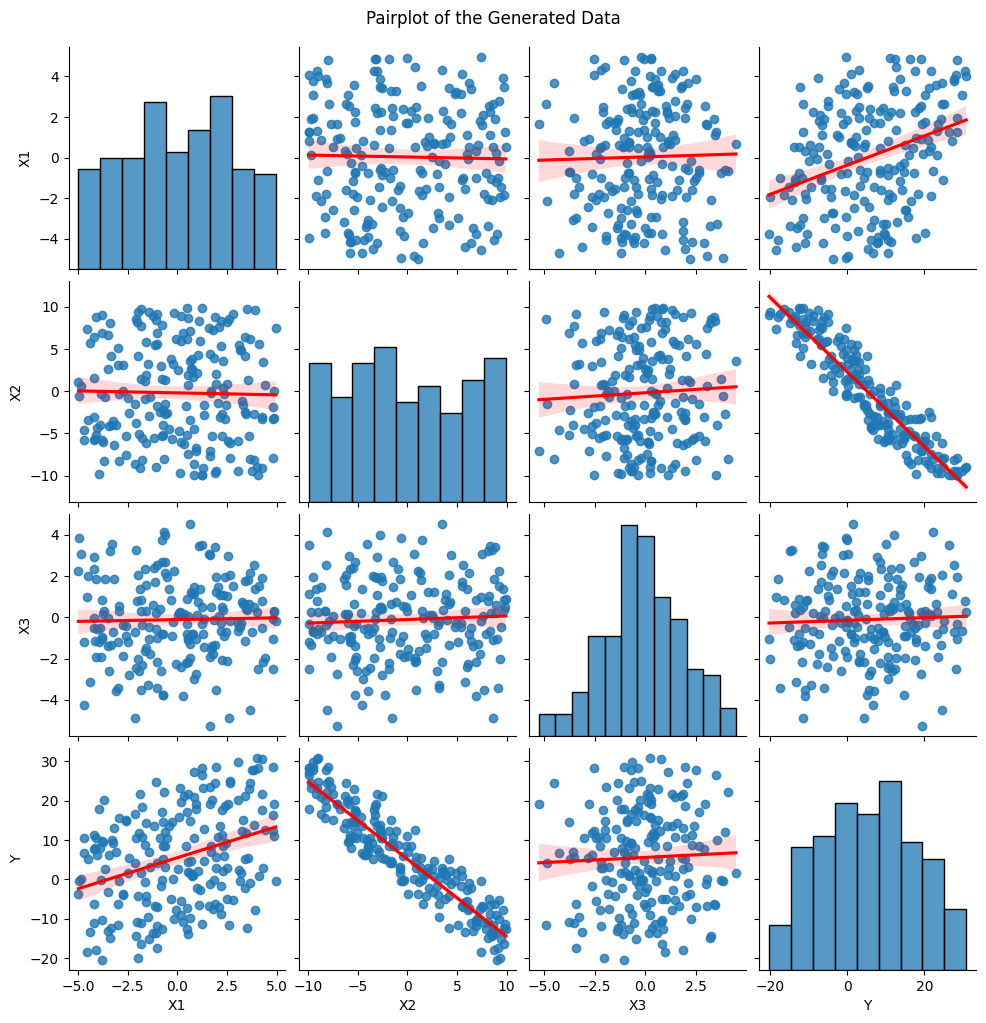

In [4]:
print(df.describe())

sns.pairplot(df, kind='reg', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle("Pairplot of the Generated Data", y=1.02)
plt.show()

## 2. Manual OLS Computation (Matrix Form)

We make the hypothesis of a linear relationship between the data, yielding a model of the form: 
$$
   \mathbf{Y} = X \boldsymbol{\beta} + \boldsymbol{\epsilon},
$$
where $X$ is an $N \times p$ matrix (including the column of ones for the intercept).

In closed form, Ordinary Least Squares is described by:
$$
   \hat{\boldsymbol{\beta}} = \bigl(X^\top X\bigr)^{-1} X^\top \mathbf{Y}.
$$

### Exercise:
1. Construct the design matrix manually.
2. Compute $\hat{\beta}$ using `np.linalg.inv(...)`.
3. Compare with the true coefficients `beta_true`.
4. Compare with `statsmodels` OLS results.

Note: the `np.ones` column that we include in the $X$ feature matrix allows the regression of the intercept (i.e. allows to determine the value of $y$ if all features $x$ are $0$).

## 3. Residual Analysis and Tests

Once we have the fitted model, let's analyze **residuals**:
$$
  e_i = y_i - \hat{y}_i.
$$

In [5]:
residuals = model_ols.resid
fitted_vals = model_ols.fittedvalues

NameError: name 'model_ols' is not defined

When evaluating the quality of a regression model, it is crucial to check whether the underlying assumptions hold (i.e. the initial hypothesis of linear relationship that we have stated in the beginning). Two common residual diagnostic plots are:

### 1. Residuals vs. Fitted Plot
- **Purpose**: This plot helps detect **non-linearity** and **heteroscedasticity** (unequal variance of residuals).
- **How it works**:
  - The **x-axis** represents the fitted (predicted) values from the regression model.
  - The **y-axis** represents the residuals (errors).
  - Ideally, the residuals should be randomly scattered around zero, forming a **homogeneous "cloud"**.
- **Interpretation**:
  - If a clear pattern (e.g., a curve) appears, it suggests **non-linearity**, meaning the model might be missing key features or transformations.
  - If the spread of residuals **increases or decreases systematically**, it indicates **heteroscedasticity**, meaning the variance of errors is not constant, which violates regression assumptions.

In [ ]:
# Residual vs. Fitted
plt.figure(figsize=(10, 8))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted")
plt.grid()
plt.show()

### **2. Normal Q-Q Plot (Quantile-Quantile Plot)**
- **Purpose**: Checks whether the residuals follow a **normal distribution**, a key assumption in many regression analyses.
- Note: if it is not the case, using the knowledge about the distribution could help.
- **How it works**:
  - The **x-axis** shows the theoretical quantiles (expected values under normality).
  - The **y-axis** shows the actual quantiles from the residuals.
  - If the residuals are normally distributed, they should closely follow a **straight diagonal line**.
- **Interpretation**:
  - **Straight-line alignment**: Residuals are normally distributed.
  - **Deviations (e.g., S-shape, heavy tails, skewed distribution)**: Suggests non-normal residuals, which might indicate missing variables, skewed data, or influential outliers.

### Exercise
For the previously computed residuals, show the Q-Q plot, either in plain Matplotlib, or using the `probplot` function.

## 4. Input Transformations (Polynomial)

When we talk about **linear regression**, we mean that the model is **linear in parameters**, not necessarily in the input variables $X$. That is, the target variable $y$ is modeled as a **linear combination of parameters**:

$$
y = \beta_0 + \beta_1 f_1(X) + \beta_2 f_2(X) + \dots + \beta_n f_n(X) + \epsilon
$$

where:
- $ \beta_0, \beta_1, \dots, \beta_n $ are the regression coefficients.
- $ f_i(X) $ are **functions of the input features** (which can be non-linear transformations like squares or interaction terms).
- $ \epsilon $ is the error term.

### **Example: Still a Linear Model**
Even if we introduce **non-linear transformations** of $X$, as long as the model is **linear in the parameters** $ \beta_i $, it is still considered a **linear model**. For example:

$$
y = \beta_0 + \beta_1 X + \beta_2 X^2 + \epsilon
$$

This model includes a quadratic term ($X^2$), but is still a **linear regression model** because it remains a linear combination of the parameters $\beta_0, \beta_1, \beta_2$.

### **What Would NOT Be a Linear Model?**
A regression model becomes **non-linear in parameters** if the parameters appear in a non-linear way. For example:

$$
y = \beta_0 + e^{\beta_1 X} + \epsilon
$$

or

$$
y = \frac{1}{\beta_0 + \beta_1 X} + \epsilon
$$

These models are **non-linear in parameters** because the relationship between $y$ and the $\beta$ coefficients is no longer a simple linear combination.

---

## **Why Use Polynomial Features in Linear Regression?**
Since linear regression allows us to use **non-linear transformations of $X$** while keeping the model linear in parameters, we can **extend linear regression** to capture more complex relationships.

### **Polynomial Feature Expansion**
Given original features $ X_1, X_2, X_3 $, we can introduce:
- **Squared terms**: $ X_1^2, X_2^2, X_3^2 $ → captures curvature.
- **Interaction terms**: $ X_1X_2, X_1X_3, X_2X_3 $ → captures relationships between variables.

By expanding the features in this way, we allow a linear regression model to **approximate non-linear patterns** in the data, making it more flexible while maintaining its interpretability.

### **Example**
A second-degree polynomial regression model:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_1^2 + \beta_5 X_2^2 + \beta_6 X_3^2 + \beta_7 X_1X_2 + \beta_8 X_1X_3 + \beta_9 X_2X_3 + \epsilon
$$

This is still **a linear model in parameters** but now captures non-linear relationships in $X$.

---

### **How to Implement Polynomial Features in Python**
In Python, we can generate polynomial features using `sklearn.preprocessing.PolynomialFeatures`

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(df[['X1','X2','X3']])
print("Original shape:", df[['X1','X2','X3']].shape)
print("Polynomial shape:", X_poly.shape)

# Build a new design matrix with intercept for manual OLS:
X_poly_mat = np.column_stack([np.ones(N), X_poly])  # shape: (N, num_features+1)

### Exercise
Perform manually the OLS method to do the polynomial regression of the previously defined `Y` vector according to the polynomial $X$ matrix.
Recall: in closed form, Ordinary Least Squares is described by:
$$
   \hat{\boldsymbol{\beta}} = \bigl(X^\top X\bigr)^{-1} X^\top \mathbf{Y}.
$$

## 5. FPE vs MSE
We can use the Final Predicted Error instead of the Mean Squared Error, since (as shown in the theroretical course, slides 27-31), the MSE is biased and the FPE solves the bias problem.
To show the difference between both estimations of the error, we will try to fit some data that follow some ground truth
$$y = \beta_0+ \beta_1 x_1 + \beta_2 x_2^2 + \beta_3 x_3^3 + \epsilon$$

In [ ]:
from IPython.display import display, clear_output
import time

First, we build a training set and a testing set. The training set hat $35$ points and the testing set is a vector made of equally spaced points between $[-1, 1]$, allowing the evaluation on the whole space.

In [ ]:
np.random.seed(0)

n = 3
p = n + 1
p_max = 25
N_train = 35
x = np.sort(np.random.uniform(-1, 1, N_train))

X = np.ones((N_train, 1))
for j in range(1, p_max + 1):
    X = np.hstack((X, x.reshape(-1, 1) ** j))

x_test = np.arange(-1, 1.01, 0.01)
X_test = np.ones((len(x_test), 1))
for j in range(1, p_max + 1):
    X_test = np.hstack((X_test, x_test.reshape(-1, 1) ** j))

beta = np.hstack(([1], np.arange(1, n + 1))).reshape(-1, 1)

f = X[:, :p] @ beta
f_test = X_test[:, :p] @ beta

Y = f.flatten()
Y_test = f_test.flatten()

In [ ]:
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")
print(f"X test shape: {X_test.shape}")
print(f"Y test shape: {Y_test.shape}")

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, Y_test)
plt.grid()
plt.show()

We add noise to the data:

In [ ]:
sd_w = 0.5
Y = Y + np.random.normal(0, sd_w, N_train)
Y_test = Y_test + np.random.normal(0, sd_w, len(f_test))

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(x_test, Y_test)
plt.grid()
plt.show()

In [ ]:
R_emp = []
MISE = []
FPE = []
PSE = []
no_par = []
fig, ax = plt.subplots(5, 5, figsize=(25, 25))

for a in range(5):
    for b in range(5):
        i = a*5 + b + 1
        XX = X[:, :i]
        invX = np.linalg.pinv(XX.T @ XX)
        beta_hat = invX @ XX.T @ Y
        Y_hat = XX @ beta_hat
    
        XXts = X_test[:, :i]
        Y_hats = XXts @ beta_hat
        no_par.append(i)
    
        e = Y - Y_hat
        R_emp.append((e.T @ e) / N)
        sde2hat = (e.T @ e) / (N - i)
    
        ax[a, b].plot(x_test, f_test, label='True function', color='green', linewidth=3)
        ax[a, b].scatter(x, Y, label='Data Points', color='blue')
        ax[a, b].plot(x_test, Y_hats, label='Fitted function', color='red')
        ax[a, b].set_ylim(min(Y), max(Y))
        ax[a, b].legend()
        ax[a, b].grid()
        
        e_ts = Y_test - Y_hats
        MISE.append((e_ts.T @ e_ts) / N)
        FPE.append(((1 + i / N) / (1 - i / N)) * (e.T @ e) / N)
        PSE.append((e.T @ e) / N + 2 * sde2hat * i / N)
        
        ax[a, b].set_title(f"degree={i}; MISE_emp={MISE[i-1]:.4f};\nFPE={FPE[i-1]:.2f}; PSE={PSE[i-1]:.3f}")
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(np.array(no_par) - 1, R_emp, label='Empirical risk')
axs[0, 0].set_xlabel("# parameters")
axs[0, 0].set_ylabel("Empirical risk")
axs[0, 0].set_title("Empirical risk")
axs[0, 0].grid()

axs[0, 1].plot(np.array(no_par) - 1, MISE, label='Generalization error')
axs[0, 1].set_xlabel("# parameters")
axs[0, 1].set_ylabel("Generalization error")
axs[0, 1].set_title("Generalization error")
axs[0, 1].grid()

axs[1, 0].plot(np.array(no_par) - 1, FPE, label='FPE')
axs[1, 0].set_xlabel("# parameters")
axs[1, 0].set_ylabel("FPE")
axs[1, 0].set_title("FPE")
axs[1, 0].grid()

axs[1, 1].plot(np.array(no_par) - 1, PSE, label='PSE')
axs[1, 1].set_xlabel("# parameters")
axs[1, 1].set_ylabel("PSE")
axs[1, 1].set_title("PSE")
axs[1, 1].grid()

plt.tight_layout()
plt.show()

print(f"which.min(R.emp)={np.argmin(R_emp) + 1}")
print(f"which.min(MISE)={np.argmin(MISE) + 1}")
print(f"which.min(FPE)={np.argmin(FPE) + 1}")
print(f"which.min(PSE)={np.argmin(PSE) + 1}")

## 6. Ridge Regression (Separate Section)

For complex expansions (like polynomial of high degree or many RBF components), **overfitting** can happen. 
Ridge regression adds an L2 penalty:
$$
  \min_{\beta} \;\; \| Y - X \beta \|^2 + \alpha \| \beta \|^2.
$$

### 6.1 Ridge Closed-form (Optional Manual)

Ridge also has a known closed-form:
$$
  \hat{\beta}_{\mathrm{ridge}} = (X^\top X + \alpha I)^{-1} X^\top Y.
$$

We'll show a manual solution, then compare to scikit-learn. We'll do it on the **polynomial features** for illustration.


In [ ]:
# 6.1 Manual ridge on polynomial features
alpha_ridge = 10.0
I_p = np.eye(X_poly_mat.shape[1])  # dimension p x p, where p = number of poly features + 1 (intercept)

# Usually we do not regularize the intercept, so we might set I_p[0,0] = 0.
# Let's do that to avoid shrinking the intercept:
I_p[0,0] = 0.0

XTX_ridge = X_poly_mat.T @ X_poly_mat + alpha_ridge*I_p
XTX_ridge_inv = np.linalg.inv(XTX_ridge)
XTy_ridge = X_poly_mat.T @ y_vec
beta_hat_ridge_manual = XTX_ridge_inv @ XTy_ridge
beta_hat_ridge_manual = beta_hat_ridge_manual.flatten()

print("Manual Ridge (polynomial) shape:", beta_hat_ridge_manual.shape)
print("Manual Ridge Coeffs (first 10):", beta_hat_ridge_manual[:10], "...")

In [ ]:
# 6.2 Compare with scikit-learn Ridge
from sklearn.linear_model import Ridge

ridge_sklearn = Ridge(alpha=alpha_ridge, fit_intercept=False) 
# "fit_intercept=False" because we already included the intercept column in X_poly_mat
# We will manually set the intercept to match the first column or we can remove intercept from X_poly_mat.

ridge_sklearn.fit(X_poly_mat, df['Y'])
beta_hat_ridge_sklearn = ridge_sklearn.coef_

print("scikit-learn Ridge Coeffs (first 10):", beta_hat_ridge_sklearn[:10])
print("\nDifference (manual - sklearn):", 
      (beta_hat_ridge_manual - beta_hat_ridge_sklearn)[:10])



They should be nearly identical (tiny floating discrepancies may occur).

### 6.3 Residual analysis for Ridge


In [ ]:
y_pred_ridge = X_poly_mat @ beta_hat_ridge_manual
resid_ridge = df['Y'] - y_pred_ridge

plt.figure(figsize=(10, 5))
plt.scatter(y_pred_ridge, resid_ridge, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Fitted values (Ridge, polynomial)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Fitted (Ridge)")
plt.grid()
plt.show()


**Remarks**:
- As alpha_ridge increases, the polynomial coefficients shrink more, typically reducing variance (but possibly increasing bias).
- We can further use cross-validation to select alpha automatically or do a hyperparameter grid.

---

## Final Comments

**In this TP**:
1. We generated **multivariate** synthetic data with known coefficients.
2. **Manually computed** the OLS solution and compared results with `statsmodels` OLS.
4. **Performed residual tests** (residual vs. fitted, Q-Q plots).
5. Introduced **Polynomial expansions** and **RBF expansions** 
6. Introduced **Ridge regression**.

This workflow demonstrates how to:
- Implement linear models using the **closed-form** normal equations.
- Expand the feature space to handle **non-linear** relationships.
- Use **regularization** (ridge) to mitigate overfitting in high-dimensional expansions.

*End of TP2*.
